# Intra-day Trading with Facebook Prophet

In [1]:
# Libraries
from eod import EodHistoricalData
import pandas as pd
from datetime import datetime, timedelta
import calendar
from tqdm import tqdm
import numpy as np
import random
import plotly.express as px
from prophet import Prophet

# Importing and assigning the api key
with open("../../eodHistoricalData-API.txt", "r") as f:
    api_key = f.read()
    
# EOD Historical Data client
client = EodHistoricalData(api_key)

# Getting Price Data

In [35]:
def getIntradayPrices(crypto, n_hours, training_hours, mov_avg):
    """
    Gets crypto prices from now to N days ago and training amount will be in addition 
    to the number of days to train. (According to the EOD documentation: The maximum 
    periods between ‘from’ and ‘to’ are 120 days for 1-minute interval, 600 days 
    for 5-minute interval and 7200 days for 1 hour interval.)
    """
    
    # Getting the date from N days ago
    ago = datetime.utcnow() - timedelta(hours=n_hours+training_hours)
    
    # Getting the unix timestamp format for the intraday data from the API
    timestamp_unix = str(calendar.timegm(ago.utctimetuple()))
    
    # Retrieving price data
    resp = client.get_prices_intraday(
        crypto+'-USD.CC', 
        interval="1h", 
        from_=timestamp_unix
    )
    
    # Removing the last time period for uniformity if necessary
    if resp[-1]['datetime'][-5:-3] != "00":
        resp = resp[:-1]
    
    # Price formatting for the dataframe
    prices = pd.DataFrame(resp)
        
    # Filling NaNs with the most recent values for any missing data
    prices = prices.fillna(method='ffill')
    
    # Getting the N Day Moving Average and rounding the values for some light data preprocessing
    prices['MA'] = prices[['open']].rolling(
        window=mov_avg
    ).mean().apply(lambda x: round(x, 6))

    # Resetting format for FBP
    prices = prices.rename(
        columns={"datetime": "ds", "MA": "y"}
    )
    
    return prices

In [38]:
prices = getIntradayPrices(
    crypto="BTC", 
    n_hours=100, 
    training_hours=50, 
    mov_avg=5
)

In [39]:
prices.shape

(135, 9)

# Time Series Analysis with Facebook Prophet

In [40]:
def fbpTrainPredict(df, forecast_hours):
    """
    Uses FB Prophet and fits to a appropriately formatted DF. Makes a prediction N days into 
    the future based on given forecast period. Returns predicted values as a DF.
    """
    # Setting up prophet
    m = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False
    )
    
    # Fitting to the prices
    m.fit(df[['ds', 'y']])
    
    # Future DF
    future = m.make_future_dataframe(
        periods=forecast_hours,
        freq="H",
        include_history=False
    )
        
    # Predicting values
    forecast = m.predict(future)

    # Returning a set of predicted values
    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Making Predictions over time

In [56]:
def runningFBP(prices, forecast_hours, training_hours):
    """
    Runs Facebook Prophet to get predictions over a set period 
    of time. Uses FBP to train and predict every hour and gets the 
    price forecasts in the next N hours.
    """
    # DF for the predicted values
    pred_df = pd.DataFrame()

    # Running the model each day
    for i in tqdm(range(training_hours, len(prices))):

        # Training and Predicting the last hour on the forecast
        forecast = fbpTrainPredict(
            prices[i-training_hours:i], 
            forecast_hours
        ).tail(1)[[
            'ds',
            'yhat',
            'yhat_lower',
            'yhat_upper'
        ]]
        
        # Adding the forecast predicted
        pred_df = pred_df.append(forecast, ignore_index=True)
                
    # Prepping for merge by converting date values to be the same type
    pred_df['ds'] = pred_df['ds'].apply(str)

    prices['ds'] = prices['ds'].apply(str)
    
    # Shifting the forecasts back in order to compare it to the 'current' open values
    pred_df[['yhat', 'yhat_lower', 'yhat_upper']] = pred_df[['yhat', 'yhat_lower', 'yhat_upper']].shift(-forecast_hours)
    
    # Merging with the prices DF in order to compare values for positions later
    merge_df = prices[['ds', 'open']].merge(
        pred_df,
        on='ds',
        how='outer'
    ).dropna().set_index('ds')

    return merge_df

# Running Both Functions
Training hours should both be equal

In [57]:
# Getting Price data
prices = getIntradayPrices(
    crypto="BTC", 
    n_hours=100, 
    training_hours=50, 
    mov_avg=5
)

# Predicting over time
pred_df = runningFBP(
    prices, 
    forecast_hours=5, 
    training_hours=50
)

  0%|          | 0/84 [00:00<?, ?it/s]

50


  1%|          | 1/84 [00:00<01:05,  1.26it/s]

51


  2%|▏         | 2/84 [00:01<01:04,  1.27it/s]

52


  4%|▎         | 3/84 [00:02<01:02,  1.30it/s]

53


  5%|▍         | 4/84 [00:03<01:00,  1.33it/s]

54


  6%|▌         | 5/84 [00:03<01:01,  1.29it/s]

55


  6%|▌         | 5/84 [00:04<01:08,  1.16it/s]


KeyboardInterrupt: 

# Determining Positions

In [45]:
def fbpPositions(pred_df, short=True):
    """
    Gets positions based on the predictions and the actual values. This
    is the logic of the trading strategy.
    """
    if pred_df['open'] < pred_df['yhat_lower']:
        return 1
    elif pred_df['open'] > pred_df['yhat_upper'] and short:
        return -1
    else:
        return 0

## Getting Other Positions

In [46]:
# Adding sentiment positions to the forecast DF
positions = pred_df

# Getting forecast prophet positions
positions['fbp_positions'] = positions.apply(
    lambda x: fbpPositions(x, short=True), 
    axis=1
)

# Buy and hold position
positions['buy_hold'] = 1

# Random positions
positions['random_positions'] = random.choices(
    [1,0,-1], k=len(positions)
)

# Performing Backtest

In [47]:
# Getting returns each hour
log_returns = prices[['ds', 'open']].set_index(
    'ds'
).loc[positions.index].apply(np.log).diff()

In [48]:
# The positions to backtest (shifted ahead by 1 to prevent lookahead bias)
bt_positions = positions[[
    'buy_hold', 
    'random_positions',
    'fbp_positions'
]].shift(1)

# The returns during the backtest
returns = bt_positions.multiply(
    log_returns['open'], 
    axis=0
)

# Inversing the log returns to get daily portfolio balance
performance = returns.cumsum().apply(
    np.exp
).dropna().fillna(
    method='ffill'
)

In [49]:
# Displaying the final balance of the portfolio
performance.tail(1)

,buy_hold,random_positions,fbp_positions
ds,,,
2022-01-09 02:00:00,0.90122,0.881062,0.986653


# Visualizing the Backtest Performance

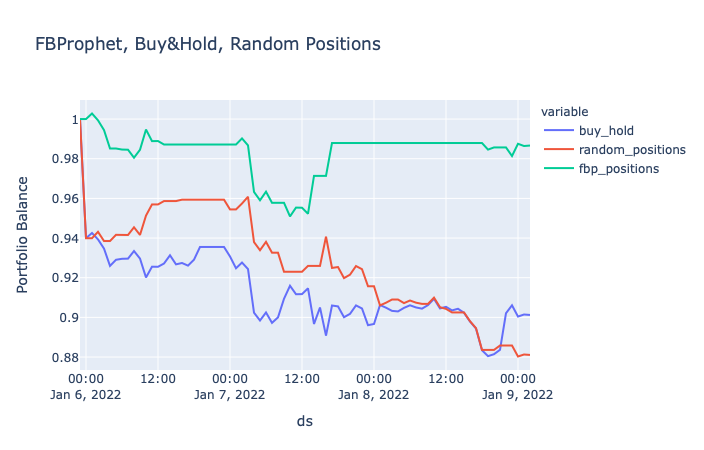

In [51]:
# Visualizing results
fig = px.line(
    performance,
    x=performance.index,
    y=performance.columns,
    title='FBProphet, Buy&Hold, Random Positions',
    labels={"value": "Portfolio Balance",
            "index": "Date"}
)

fig.show()

# Backtesting and Visualization Function

In [53]:
def backtestPerformanceVis(ticker, n_hours, training_hours, mov_avg, forecast_hours):
    """
    Consolidates the previous functions that support the backtesting process.
    """
    # Getting Price data
    print("Getting price data...")
    prices = getIntradayPrices(
        crypto=ticker, 
        n_hours=n_hours, 
        training_hours=training_hours, 
        mov_avg=mov_avg
    )

    # Predicting over time
    print("Running predictions...")
    pred_df = runningFBP(
        prices, 
        forecast_hours=forecast_hours, 
        training_hours=training_hours
    )
    
    # Adding sentiment positions to the prediction DF
    print("Getting positions...")
    positions = pred_df

    # Getting forecast prophet positions
    positions['fbp_positions'] = positions.apply(
        lambda x: fbpPositions(x, short=True), 
        axis=1
    )

    # Buy and hold position
    positions['buy_hold'] = 1

    # Random positions
    positions['random_positions'] = random.choices(
        [1,0,-1], k=len(positions)
    )
    
    # Getting returns each hour
    print("Performing the backtest...")
    log_returns = prices[['ds', 'open']].set_index(
        'ds'
    ).loc[positions.index].apply(np.log).diff()
    
    # The positions to backtest (shifted ahead by 1 to prevent lookahead bias)
    bt_positions = positions[[
        'buy_hold', 
        'random_positions',
        'fbp_positions'
    ]].shift(1)

    # The returns during the backtest
    returns = bt_positions.multiply(
        log_returns['open'], 
        axis=0
    )

    # Inversing the log returns to get daily portfolio balance
    performance = returns.cumsum().apply(
        np.exp
    ).dropna().fillna(
        method='ffill'
    )
    
    # Displaying the final balance of the portfolio
    print("Final Performance:")
    display(performance.tail(1))
    
    # Visualizing results
    fig = px.line(
        performance,
        x=performance.index,
        y=performance.columns,
        title='FBProphet, Buy&Hold, Random Positions',
        labels={"value": "Portfolio Balance",
                "index": "Date"}
    )

    return fig.show()

Getting price data...


  0%|          | 0/63 [00:00<?, ?it/s]

Running predictions...


100%|██████████| 63/63 [00:59<00:00,  1.06it/s]

Getting positions...
Performing the backtest...
Final Performance:


,buy_hold,random_positions,fbp_positions
ds,,,
2022-01-09 02:00:00,0.973137,1.032958,0.96184


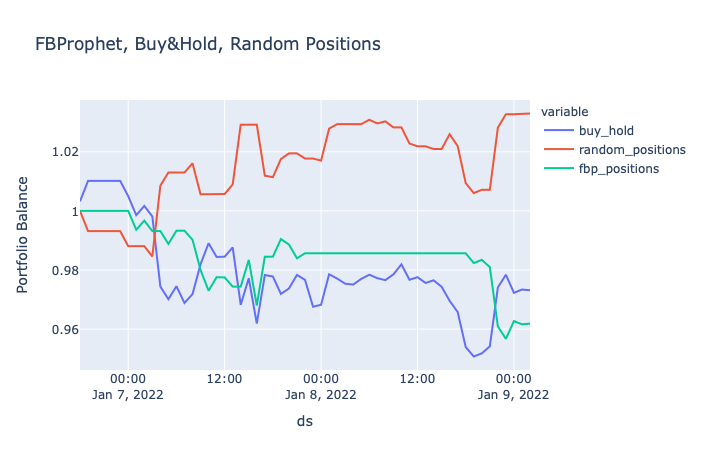

In [55]:
backtestPerformanceVis(
    ticker="BTC", 
    n_hours=80, 
    training_hours=40, 
    mov_avg=3, 
    forecast_hours=3
)